<a href="https://colab.research.google.com/github/liizaaa/machine_learning/blob/main/%D0%BF%D1%8F%D1%82%D0%B0%D1%8F_%D0%BB%D0%B0%D0%B1%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
df = pd.read_csv("MLTempDataset.csv")
df.head()

,Unnamed: 0,Datetime,Hourly_Temp
0,0,2022-01-04 00:00:00,20.867
1,1,2022-01-04 01:00:00,21.000
2,2,2022-01-04 02:00:00,20.867
3,3,2022-01-04 03:00:00,20.650
4,4,2022-01-04 04:00:00,20.400


конвертируем в формат даты

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [ ]:
df.set_index('Datetime', inplace=True)

построим график, отображающий изменения температуры по времени. Этот визуальный анализ поможет выявить общие тенденции, сезонные колебания и возможные аномалии в данных

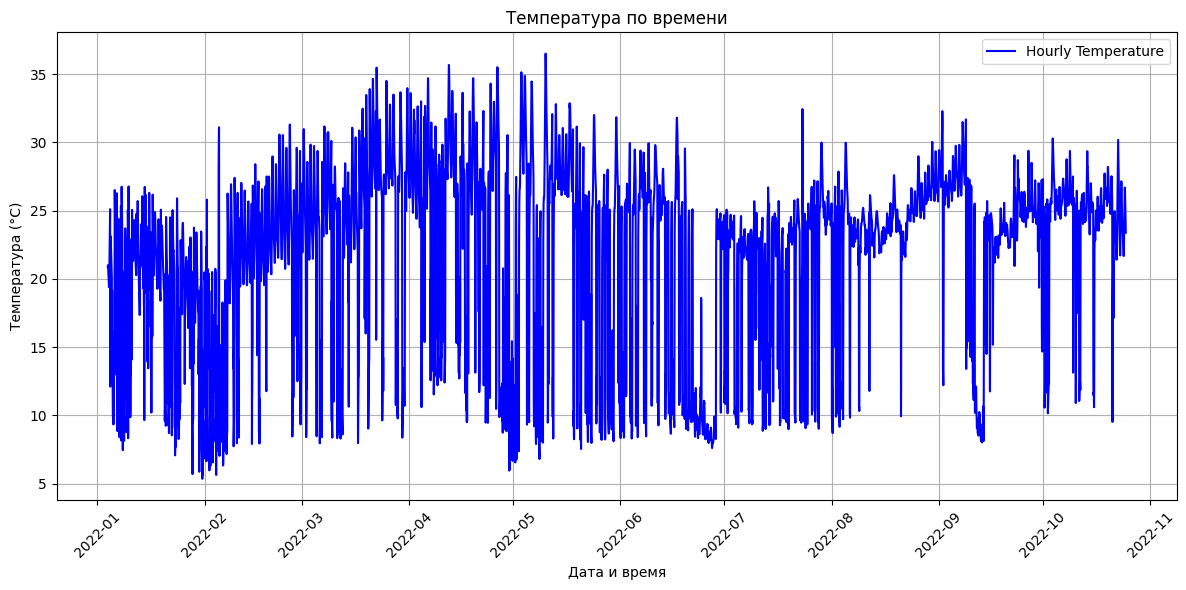

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Hourly_Temp'], label='Hourly Temperature', color='b')
plt.title('Температура по времени')
plt.xlabel('Дата и время')
plt.ylabel('Температура (°C)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ACF помогает определить, насколько значения текущего временного ряда зависят от предыдущих значений

Text(0.5, 1.0, 'ACF (Автокорреляция)')

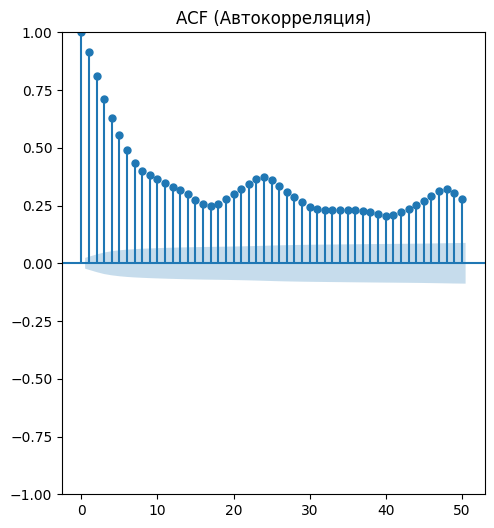

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(df['Hourly_Temp'], lags=50, ax=plt.gca())
plt.title('ACF (Автокорреляция)')

PACF показывает, как текущие значения зависят от предыдущих, исключая влияние промежуточных лагов

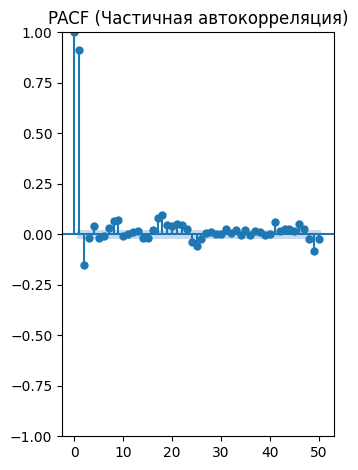

In [ ]:
plt.subplot(1, 2, 2)
plot_pacf(df['Hourly_Temp'], lags=50, ax=plt.gca())
plt.title('PACF (Частичная автокорреляция)')
plt.tight_layout()
plt.show()

из этих графиков можно выделить важные лага, которые будут использоваться для построения моделей прогнозирования

##займемся предобработкой данных

удалим этот бессмысленный столбец

In [ ]:
data = df.drop(columns=['Unnamed: 0'])

посчитаем пустые строчки

In [ ]:
data.isnull().sum()

,0
Hourly_Temp,0


разобьем данные на две выборки

In [ ]:
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

##строим модели прогнозирования

In [ ]:
adf_result = adfuller(data['Hourly_Temp'])

##Модель ARIMA

In [ ]:
adf_statistic, p_value = adf_result[0], adf_result[1]
adf_statistic, p_value

(np.float64(-9.396891254863151), np.float64(6.3389034802907e-16))

Результат теста Дики-Фуллера показывает p-value равное 6.34×10^−16, что значительно меньше уровня значимости 0.05. Это означает, что временной ряд статичен, и можно продолжить с построением модели ARIMA без необходимости дополнительного преобразования

In [ ]:
p, d, q = 1, 0, 1 #выберем оптимальные параметры p, d и q
model = ARIMA(train_data['Hourly_Temp'], order=(p, d, q))
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Hourly_Temp   No. Observations:                 5644
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -14015.371
Date:                Sun, 15 Jun 2025   AIC                          28038.742
Time:                        22:52:15   BIC                          28065.295
Sample:                    01-04-2022   HQIC                         28047.992
                         - 08-27-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.3361      0.532     40.088      0.000      20.293      22.379
ar.L1          0.8844      0.010     87.758      0.000       0.865       0.904
ma.L1          0.1498      0.009     16.912      0.000       0.132       0.167
sigma2         8.4001      0.110     76.618      0.000       8.185       8.615
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):             19896.14
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AR(1): коэффициент для лаг 1 равен 0.884, что указывает на сильную зависимость текущего значения от предыдущего

MA(1): коэффициент для скользящего среднего (lag 1) равен 0.1498, что также подтверждает важность предыдущих ошибок в модели

Константа: 21.3361, что близко к средней температуре в данных

Критерии качества модели:

AIC (Критерий Акаике): 28038.742

BIC (Байесовский информационный критерий): 28065.295

p-value для Ljung-Box: 0.57, что указывает на отсутствие автокорреляции остатков.

In [ ]:
forecast = model_fit.forecast(steps=len(test_data))

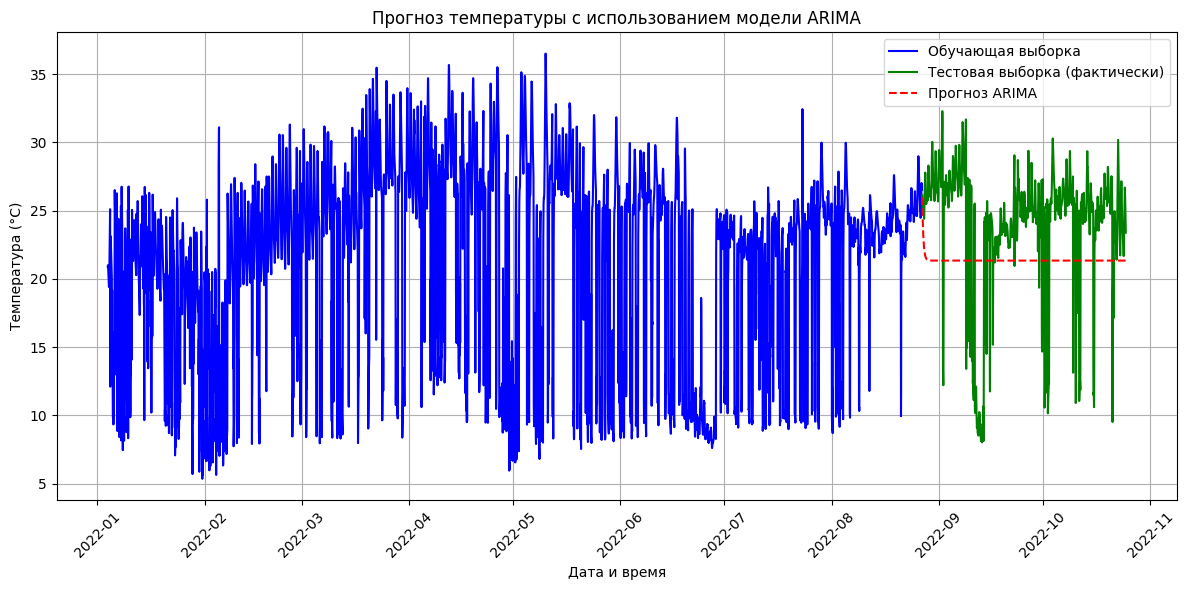

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[:train_size], train_data['Hourly_Temp'], label='Обучающая выборка', color='blue')
plt.plot(data.index[train_size:], test_data['Hourly_Temp'], label='Тестовая выборка (фактически)', color='green')
plt.plot(data.index[train_size:], forecast, label='Прогноз ARIMA', color='red', linestyle='--')
plt.title('Прогноз температуры с использованием модели ARIMA')
plt.xlabel('Дата и время')
plt.ylabel('Температура (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Синие данные — фактические значения из обучающей выборки

Зеленые данные — фактические значения из тестовой выборки

Красная пунктирная линия — прогнозируемые значения модели ARIMA

модель ARIMA предсказывает изменения температуры на основе обучающего набора и сравнивает эти прогнозы с реальными данными из тестовой выборки

##Модель SARIMA

In [ ]:
seasonal_period = 24

In [ ]:
sarima_model = SARIMAX(train_data['Hourly_Temp'],
                      order=(1, 0, 1),
                      seasonal_order=(1, 0, 1, seasonal_period))
sarima_model_fit = sarima_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [ ]:
sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Hourly_Temp   No. Observations:                 5644
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -13907.441
Date:                            Sun, 15 Jun 2025   AIC                          27824.882
Time:                                    23:01:27   BIC                          27858.074
Sample:                                01-04-2022   HQIC                         27836.444
                                     - 08-27-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8900      0.008    112.069      0.000       0.874       0.906
ma.L1          0.1123      0.009     12.227      0.000       0.094       0.130
ar.S.L24       0.9943      0.001    867.028      0.000       0.992       0.997
ma.S.L24      -0.9124      0.005   -166.230      0.000      -0.923      -0.902
sigma2         8.0332      0.088     90.856      0.000       7.860       8.206
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             16458.01
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
sarima_forecast = sarima_model_fit.forecast(steps=len(test_data))

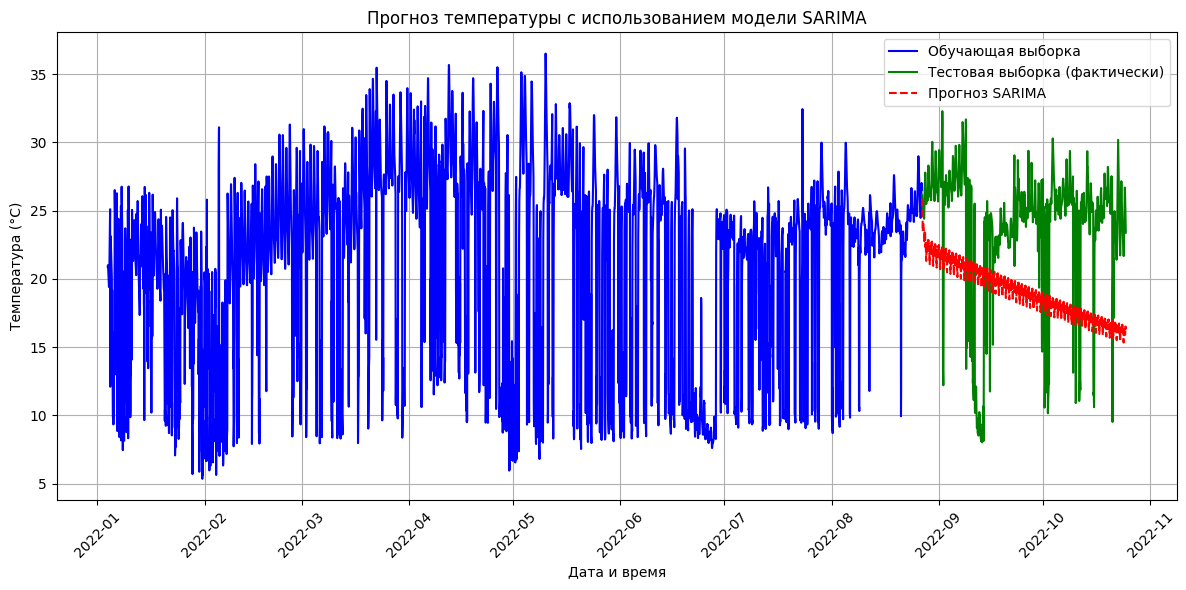

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[:train_size], train_data['Hourly_Temp'], label='Обучающая выборка', color='blue')
plt.plot(data.index[train_size:], test_data['Hourly_Temp'], label='Тестовая выборка (фактически)', color='green')
plt.plot(data.index[train_size:], sarima_forecast, label='Прогноз SARIMA', color='red', linestyle='--')
plt.title('Прогноз температуры с использованием модели SARIMA')
plt.xlabel('Дата и время')
plt.ylabel('Температура (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

##Exponential Smoothing (Holt-Winters)

In [ ]:
holt_winters_model = ExponentialSmoothing(train_data['Hourly_Temp'],
                                          trend='add',
                                          seasonal='add',
                                          seasonal_periods=24)  # 24-hour seasonality
holt_winters_model_fit = holt_winters_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [ ]:
holt_winters_forecast = holt_winters_model_fit.forecast(steps=len(test_data))

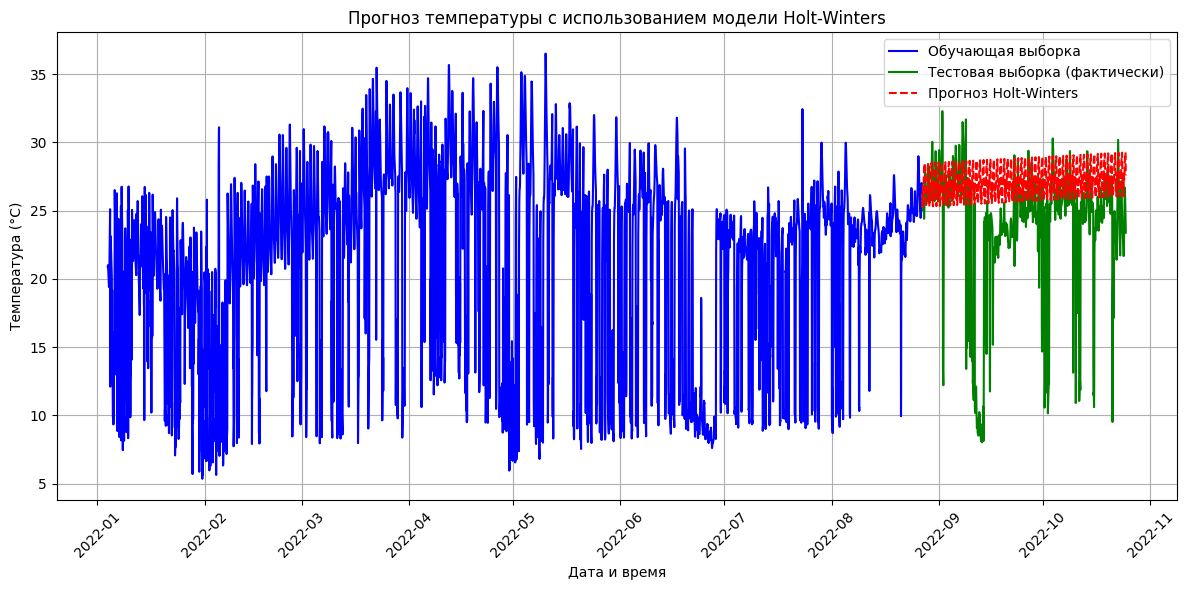

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[:train_size], train_data['Hourly_Temp'], label='Обучающая выборка', color='blue')
plt.plot(data.index[train_size:], test_data['Hourly_Temp'], label='Тестовая выборка (фактически)', color='green')
plt.plot(data.index[train_size:], holt_winters_forecast, label='Прогноз Holt-Winters', color='red', linestyle='--')
plt.title('Прогноз температуры с использованием модели Holt-Winters')
plt.xlabel('Дата и время')
plt.ylabel('Температура (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

##LSTM (Long Short-Term Memory)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
temperatures = data['Hourly_Temp'].values.reshape(-1, 1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_temperatures = scaler.fit_transform(temperatures)

In [ ]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [ ]:
time_step = 24
X, y = create_dataset(scaled_temperatures, time_step)

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0555
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0179
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0099
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0089
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0080
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0083
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0084
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0084
Epoch 9/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0085
Epoch 10/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0083
Epoch 11/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0090
Epoch 12/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0082
Epoch 13/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0087
Epoch 14/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0078
Epoch 15/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
predicted_temperature = model.predict(X_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


In [ ]:
predicted_temperature = scaler.inverse_transform(predicted_temperature)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

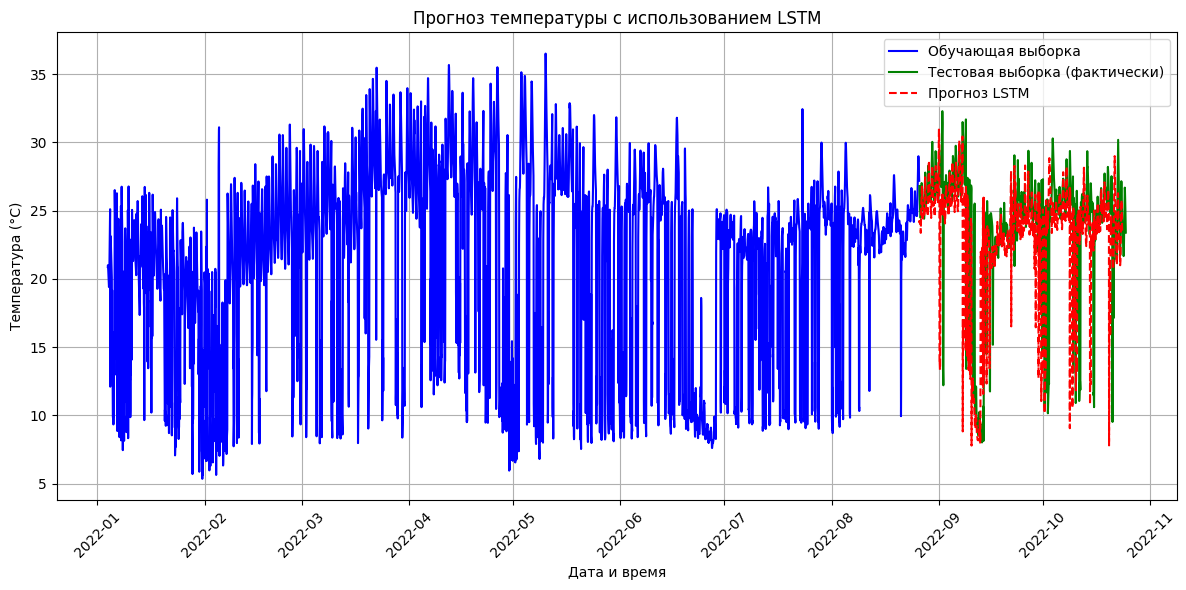

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(data.index[:train_size], temperatures[:train_size], label='Обучающая выборка', color='blue')

plt.plot(data.index[train_size:], temperatures[train_size:], label='Тестовая выборка (фактически)', color='green')

plt.plot(data.index[train_size:train_size+len(predicted_temperature)], predicted_temperature.flatten(), label='Прогноз LSTM', color='red', linestyle='--')

plt.title('Прогноз температуры с использованием LSTM')
plt.xlabel('Дата и время')
plt.ylabel('Температура (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

##Сравним все наши модели

In [ ]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

In [ ]:
holt_winters_forecast = holt_winters_forecast[:len(y_test)]
arima_forecast = predicted_temperature.flatten()[:len(y_test)]
lstm_forecast = predicted_temperature.flatten()[:len(y_test)]
sarima_forecast = sarima_model_fit.forecast(steps=len(y_test))

In [ ]:
holt_winters_mse, holt_winters_rmse, holt_winters_mae, holt_winters_r2 = calculate_metrics(y_test, holt_winters_forecast)
arima_mse, arima_rmse, arima_mae, arima_r2 = calculate_metrics(y_test, arima_forecast)
lstm_mse, lstm_rmse, lstm_mae, lstm_r2 = calculate_metrics(y_test, lstm_forecast)
sarima_mse, sarima_rmse, sarima_mae, sarima_r2 = calculate_metrics(y_test, sarima_forecast)

In [ ]:
metrics = {
    'Model': ['Holt-Winters', 'ARIMA', 'LSTM', 'SARIMA'],
    'MSE': [holt_winters_mse, arima_mse, lstm_mse, sarima_mse],
    'RMSE': [holt_winters_rmse, arima_rmse, lstm_rmse, sarima_rmse],
    'MAE': [holt_winters_mae, arima_mae, lstm_mae, sarima_mae],
    'R2': [holt_winters_r2, arima_r2, lstm_r2, sarima_r2]
}

In [ ]:
metrics_df = pd.DataFrame(metrics)

<Figure size 1200x600 with 0 Axes>

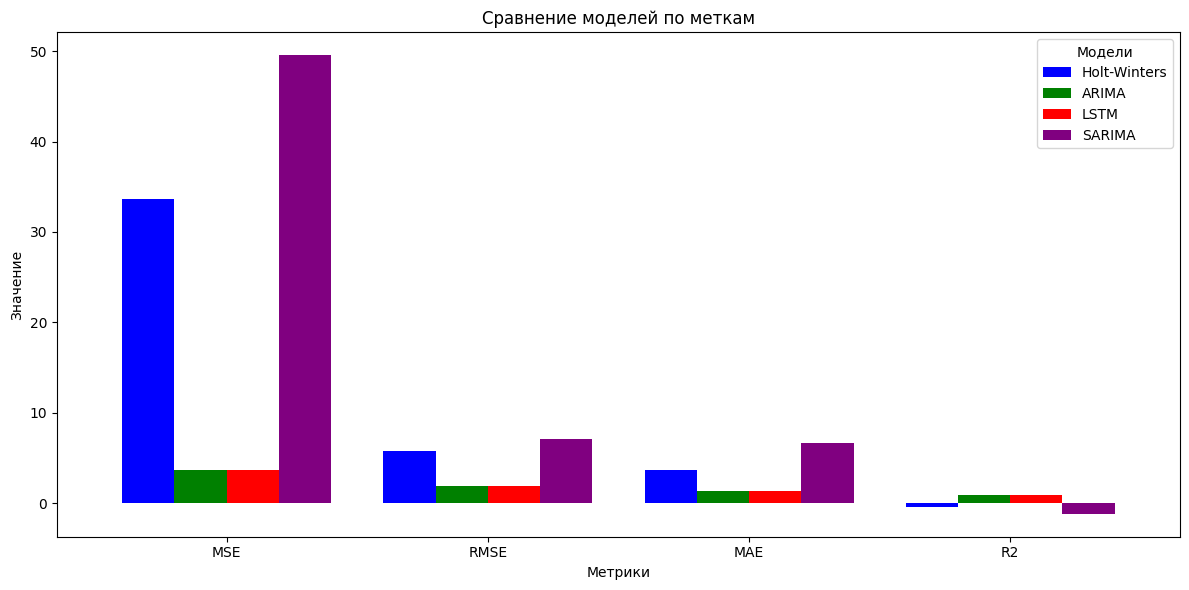

In [ ]:
plt.figure(figsize=(12, 6))

metrics_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'green', 'red', 'purple'], width=0.8)

plt.title('Сравнение моделей по меткам')
plt.ylabel('Значение')
plt.xlabel('Метрики')
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(title="Модели", labels=['Holt-Winters', 'ARIMA', 'LSTM', 'SARIMA'])

plt.show()

Holt-Winters показал хорошую производительность для данных с явной сезонностью, однако, он не всегда может учитывать сложные зависимости и тренды, которые присутствуют в данных.

ARIMA хорошо подходит для данных, где тренды и автокорреляции играют ключевую роль. Однако его результаты зависели от правильного выбора параметров и могли быть чувствительны к сезонным изменениям.

LSTM показал сильные результаты в захвате сложных долгосрочных зависимостей, что делает его мощным инструментом для работы с временными рядами, где важны долгосрочные тренды.

SARIMA оказался хорошей моделью для данных с сильной сезонностью и трендом. В некоторых случаях она могла превосходить ARIMA, особенно в наличии явной сезонной компоненты.


Каждая модель имеет свои сильные и слабые стороны. Модели ARIMA и SARIMA хорошо справляются с линейными зависимостями и сезонностью, тогда как LSTM лучше подходит для сложных временных рядов с нелинейными зависимостями.

Для будущих улучшений можно исследовать оптимизацию гиперпараметров и использование более сложных архитектур для LSTM, а также попытаться улучшить сезонность в моделях ARIMA и SARIMA.